# TD: arbres de décisions, méthodes ensemblistes et plus proches voisins

La séance d'aujourd'hui porte sur l'utilisation d'autres techniques de classification.

Le problème que l'on va traiter est celui de la prédiction du cancer à partir d'images d'histologie.

Les caractéristiques correspondent à des statistiques (moyenne, variance, valeurs extrémales) de certaines caractéristiques des noyaux des cellules.

C'est un jeu de données classique en Machine Learning. Une description plus complète est disponible à partir du [lien](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)).

<img src=https://www.frontiersin.org/files/Articles/572671/fdgth-02-572671-HTML/image_m/fdgth-02-572671-g001.jpg />

Exécuter les commandes suivantes pour charger l'environnement et les données dans la variable `data_all`.


In [2]:
# Librairies scientifique et visualisation utiles standard
%matplotlib inline
from pylab import *

import numpy as np
import random
import matplotlib.pyplot as plt

# Lecture des données
from sklearn.datasets import load_breast_cancer
data_all = load_breast_cancer()
X=data_all['data']
y=data_all['target']

# Nom des caractéristiques
fnames=data_all['feature_names'].tolist()

# Nom des classes
targets=data_all['target_names'].tolist()

# Pour séparer les données en apprentissage et test
from sklearn.model_selection import train_test_split

# Répartition en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.4)

# Données d'apprentissage réparties en fonction des classes
X0 = X_train[y_train == 0,:]
X1 = X_train[y_train == 1,:]


## Analyse préliminaire des données

Quel est le type de données, quelle est leur taille, leur type, le nombre de classes, le nombre d'échantillons, existe-t-il des dimensions de l'espace des caractéristiques qui semblent discriminantes?

Inspirez-vous des codes du TD précédent (visualistion d'histogrammes, de paires de caractéristiques, etc.) pour appréhender la complexité des données.


Les données sont de dimension 30
Le nombre de données d'apprentissage est 341
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean radius      569 non-null    float64
 1   mean texture     569 non-null    float64
 2   mean perimeter   569 non-null    float64
 3   mean area        569 non-null    float64
 4   mean smoothness  569 non-null    float64
 5   class            569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


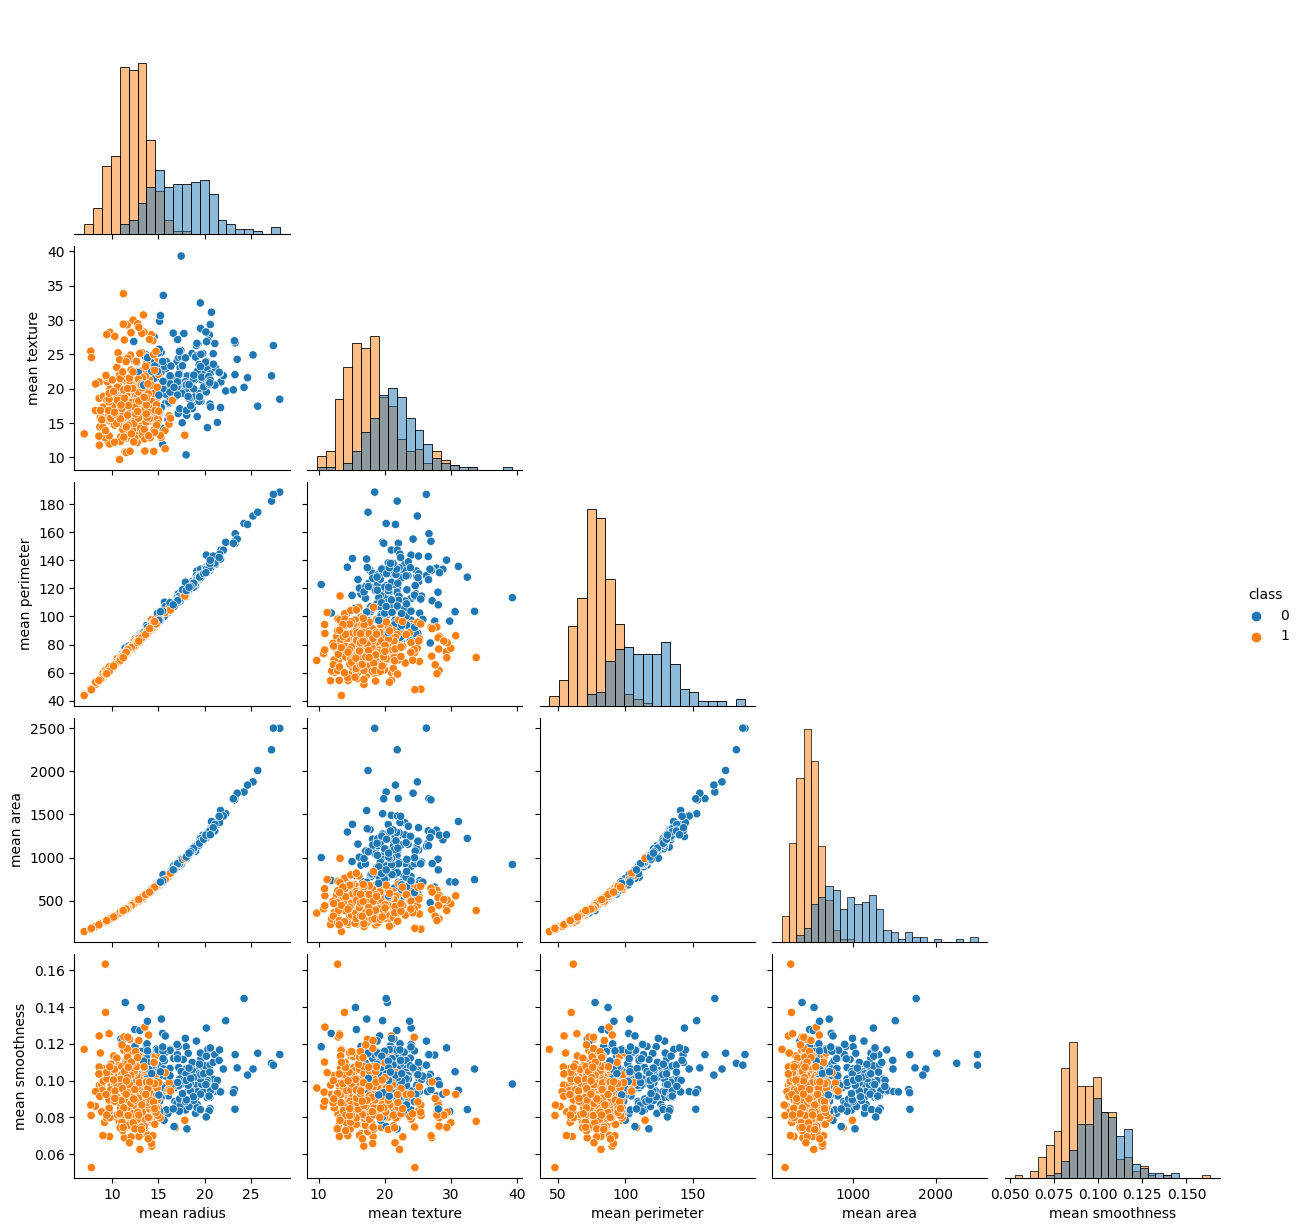

In [3]:
###############################
## Mettre votre code ici
###############################
import pandas as pd
import seaborn as sns

ndim = X_train.shape[1]
ntrain = X_train.shape[0]

print("Les données sont de dimension {:d}".format(ndim))
print("Le nombre de données d'apprentissage est {:d}".format(ntrain))

df = pd.DataFrame(X[:, 0:5], columns=fnames[0:5])
df['class'] = np.int64(y) # a new column 'class' to the DataFrame, containing the target variable y. The np.int64(y) ensures that the target variable is represented as integers.
df.info()

sns.pairplot(df, hue='class',diag_kind="hist",corner=True)



## Apprentissage d'un arbre de décision

On utilisera la bibliothèque scikit-learn [`tree`](https://scikit-learn.org/stable/modules/tree.html) pour

* Construire l'arbre sur les données d'entrainement
* Visualiser la structure de l'arbre
* Prédire le diagnostic sur les données de test
* Calculer l'erreur et la matrice de confusion

Regarder la fiche décrivant la fonction d'apprentissage d'un [arbre de décision](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), et étudier ses paramètres en vous rapportant au cours.

Faire varier certains paramètres (profondeur max, pureté, critère...) et visualisez leur influence.


### Définition de la structure de l'arbre

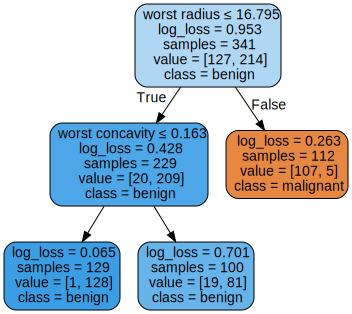

In [4]:
from sklearn import tree
import graphviz


###############################
## Faire varier les paramètres
###############################

clf = tree.DecisionTreeClassifier(criterion="log_loss", # the function to measure the quality of the split (gini, entropy, log_loss)
                                  max_depth=None, # the maximum depth of the tree, if None - expand till all leaves are pure
                                  min_samples_split=200, # the minimum number of samples required to split an internal node
                                  min_samples_leaf=100, # the minimum number of samples required to be at a leaf node
                                  splitter="best", # the strategy used to choose the split at each node
                                  random_state = None) # controls the randomness of the estimator
clf = clf.fit(X_train, y_train)

# Gnerate a GraphViz representation of the decision tree
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)

#Les instructions suivantes permettent de visualiser l'arbre.
dot_data = tree.export_graphviz(clf, out_file=None,
                    feature_names=fnames,
                    class_names=targets,
                    filled=True, rounded=True,
                    special_characters=True)
graph = graphviz.Source(dot_data)
graph


## Calcul de l'arbre

Dans cet partie, on va chercher à recalculer les valeurs fournies par la fonction de la bibliothèque.

On va chercher dans un premier temps à retrouver les valeurs du premier noeud (entropie, samples, value, class).

Calculer les probabilités

Pour rappel, l'entropie de la variable $Y$ se calcule selon:

$$ H(Y)= -\sum_k P(Y=k) \log_2 P(Y=k)$$

La fonction logarithme en base 2 est`log2` dans python.

Les probabilités peuvent s'estimer selon:

$$ P(Y_k) = \frac{n_k}{N} $$

où $n_k$ est le nombre d'échantillons de la classe $k$, et $N$ est le nombre total d'achantillons de la variable aléatoire $Y$.

In [5]:
###############################
## Mettre votre code ici
###############################

n0 = np.sum(y_train == 0)
n1 = np.sum(y_train == 1)

n = n0 + n1 # total number of samples

p0 = n0 / n
p1 = n1 / n

entropy = - (p0 * log2(p0) + p1 * log2(p1))
class_estim = targets[0 if n0 > n1 else 1]

###############################

print("== Pour le noeud racine ==")
print("samples = {}".format(n))
print("value = [{}, {}]".format(n0,n1))
print("entropy = {:.3f}".format(entropy))
print("class = {}".format(class_estim))


== Pour le noeud racine ==
samples = 341
value = [127, 214]
entropy = 0.953
class = benign


Même question pour les deux noeuds connectés au premier.

Repérer sur la visualisation du graphe le nom de la caractéristique à tester, et les seuils définissant le test.

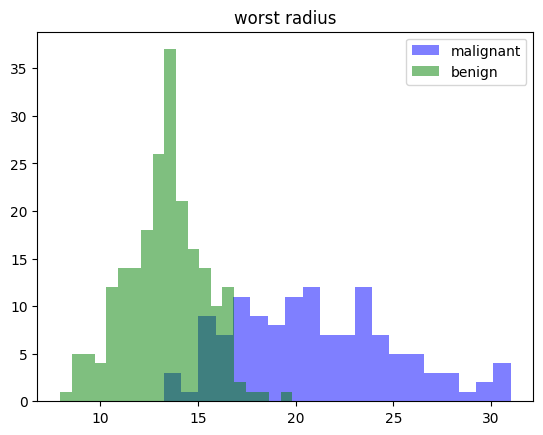

== Pour le noeud gauche ==
samples = 112
value = [107, 5]
entropy = 0.263
class = malignant

== Pour le noeud droit ==
samples = 229
value = [20, 209]
entropy = 0.428
class = benign


In [8]:
# Pour récupérer l'indice d'une caractéristique
fname = 'worst radius'
i = fnames.index(fname)

# Histogrammes des valeurs d'attributs pour chacune des classes
plt.hist(X0[:,i], color='b', alpha=0.5, bins=20, label=targets[0])
plt.hist(X1[:,i], color='g', alpha=0.5, bins=20, label=targets[1])
plt.title(fname)
plt.legend(loc='upper right')
plt.show()

###############################
## Mettre votre code ici
###############################

# Right node
y_mal = y_train[X_train[:,i] > 16.795]

n0 = np.sum(y_mal == 0)
n1 = np.sum(y_mal == 1)
n = n0 + n1

p0 = n0 / n
p1 = n1 / n

entropy = - (p0 * log2(p0) + p1 * log2(p1))
class_estim = targets[0 if n0 > n1 else 1]

print("== Pour le noeud gauche ==")
print("samples = {}".format(n))
print("value = [{}, {}]".format(n0,n1))
print("entropy = {:.3f}".format(entropy))
print("class = {}".format(class_estim))

# Left node
y_ben = y_train[X_train[:,i] <= 16.795]

n0 = np.sum(y_ben == 0)
n1 = np.sum(y_ben == 1)
n = n0 + n1

p0 = n0 / n
p1 = n1 / n

entropy = - (p0 * log2(p0) + p1 * log2(p1))
class_estim = targets[0 if n0 > n1 else 1]

print("\n== Pour le noeud droit ==")
print("samples = {}".format(n))
print("value = [{}, {}]".format(n0,n1))
print("entropy = {:.3f}".format(entropy))
print("class = {}".format(class_estim))


### Evaluation des performances du prédicteur.

Calculer la matrice de confusion, c'est à dire la matrice dont les coefficient $C_{ij}$ contient le nombre d'éléments de la classe $i$ prédits comme étant de la classe $j$.

On pourra utiliser la bibliothèque [`model_evaluation`](https://scikit-learn.org/stable/modules/model_evaluation.html).


In [11]:
# Prédiction et évaluation

#########################
## METTRE VOTRE CODE ICI
#########################
from sklearn.metrics import accuracy_score, confusion_matrix

predictions = clf.predict(X_test)

score = accuracy_score(y_test, predictions)
matrix = confusion_matrix(y_test, predictions)
print("Erreur de prédiction: {:.1f}%".format((1 - score) * 100))
print(matrix)

Erreur de prédiction: 8.3%
[[ 72  13]
 [  6 137]]



## Bagging

L'objectif de cette partie est de construire une approche de "bagging".

Le principe de l'approche est:

* Apprendre et collecter plusieurs arbres sur des échantillonnages aléatoires des données d'apprentissage
* Agréger les prédictions par vote
* Définir la classe prédite à partir des prédictions agrégées

Utiliser la fonction de scikit_learn [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) pour développer une approche de Bagging.

Mettre en évidence l'influence des paramètres, de l'aléatoire, de la nature du problème, des caractéristiques des arbres (profondeur), du nombre d'arbres sur les performances.


In [16]:
from sklearn import tree
from sklearn.ensemble import BaggingClassifier

#########################
## METTRE VOTRE CODE ICI
#########################

estimator = tree.DecisionTreeClassifier(criterion="entropy", max_depth=None, min_samples_split=200, min_samples_leaf=100, splitter="best", random_state = None)
estimator.fit(X_train, y_train)
perf_tree = estimator.score(X_test, y_test)


bagging_clf = BaggingClassifier(estimator=estimator, n_estimators=10, random_state=0)
bagging_clf.fit(X_train, y_train)
perf_bagging = bagging_clf.score(X_test, y_test)

print("DTree Error = {:.1f}%".format(100*(1-perf_tree)))

print("DTree+Bagging Error = {:.1f}%".format(100*(1-perf_bagging)))


DTree Error = 8.3%
DTree+Bagging Error = 11.0%


## Plus proches voisins

On va maintenant étudier un autre algorithme "explicable" pour réaliser la prédiction.

Utiliser la fonction de scikit-learn [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) et trouver un bon jeu de paramètres (par exemple en faisant une boucle sur ces paramètres).

Tester sur différents problèmes de prédiction.


In [19]:
from sklearn.neighbors import KNeighborsClassifier

for metric in [
    'cityblock', # manhattan distance (L1 norm)
    'euclidean', #  euclidean distance (L2 norm)
    'cosine' # cosine distance between 1-D arrays
]:

  for nn in arange(1,11):
    knn = KNeighborsClassifier(n_neighbors=nn, metric=metric)
    knn.fit(X_train, y_train)

    print("{:8s} {:2d}-NN Error = {:.1f}%".format(metric, nn,100*(1-knn.score(X_test, y_test))))


cityblock  1-NN Error = 6.6%
cityblock  2-NN Error = 9.2%
cityblock  3-NN Error = 6.6%
cityblock  4-NN Error = 7.5%
cityblock  5-NN Error = 7.0%
cityblock  6-NN Error = 7.0%
cityblock  7-NN Error = 6.6%
cityblock  8-NN Error = 6.6%
cityblock  9-NN Error = 5.7%
l2        1-NN Error = 7.5%
l2        2-NN Error = 9.2%
l2        3-NN Error = 7.9%
l2        4-NN Error = 7.9%
l2        5-NN Error = 7.5%
l2        6-NN Error = 7.5%
l2        7-NN Error = 7.0%
l2        8-NN Error = 7.5%
l2        9-NN Error = 6.6%
cosine    1-NN Error = 8.8%
cosine    2-NN Error = 10.5%
cosine    3-NN Error = 8.8%
cosine    4-NN Error = 11.8%
cosine    5-NN Error = 9.6%
cosine    6-NN Error = 11.0%
cosine    7-NN Error = 9.2%
cosine    8-NN Error = 9.2%
cosine    9-NN Error = 9.6%


### Bagging des kNN?

Une méthode de bagging est-elle possible?

Permet-elle d'améliorer les performances?

In [22]:
##########################
# METTRE CODE ICI
##########################

knn = KNeighborsClassifier(n_neighbors=5, metric="cityblock")

bagging_clf = BaggingClassifier(estimator=knn, n_estimators=10, random_state=0, bootstrap_features=True, max_features=0.5)
bagging_clf.fit(X_train, y_train)
perf_knn_bagging = bagging_clf.score(X_test, y_test)

print("kNN+Bagging Error = {:.1f}%".format(100*(1-perf_knn_bagging)))

kNN+Bagging Error = 7.0%


## Normalisation des données

Les caractéristiques peuvent avoir des distributions très différentes entre-elles. Il peut être nécessaire de les normaliser pour pouvoir les comparer.


### Comparaison des distributions


Visualiser les variances des caractéristiques.

On pourra utiliser la fonction de normalisation [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) pour calculer les variances et transformer les données.


In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

print(np.log(np.array(scaler.var_)))


[  2.48107534   3.0336091    6.34151376  11.61892432  -8.65357697
  -5.86713734  -5.01957311  -6.54131569  -7.10947159  -9.85987554
  -2.97509035  -1.24997243   1.05357724   7.01388757 -11.55504798
  -7.95097935  -6.72015753 -10.0869017   -9.45792119 -11.66007015
   3.13013858   3.69870075   7.01025623  12.61238051  -7.57322405
  -3.59576584  -2.96536528  -5.3874798   -5.47245996  -7.92091523]


### Normalisation pour les plus proches voisins

Comparer les résultats de classification avec les données normalisées (en moyenne et variance).

Avez-vous une explication de la différence?

In [27]:
########################
## METTRE VOTRE CODE ICI
########################

knn = KNeighborsClassifier(n_neighbors=5, metric="cityblock")
knn.fit(X_train, y_train)
perf_knn = knn.score(X_test, y_test)

print("kNN Error = {:.1f}%".format(100*(1-perf_knn)))

norm_X_train = scaler.transform(X_train)
norm_x_test = scaler.transform(X_test)

knn.fit(norm_X_train, y_train)
perf_knn_norm = knn.score(norm_x_test, y_test)

print("kNN Error + Normalization = {:.1f}%".format(100*(1-perf_knn_norm)))


kNN Error = 7.0%
kNN Error + Normalization = 4.4%


### Comparaison de l'impact de la normalisation sur d'autres algorithmes

Reprendre les codes du TD précédent et esimer les performances d'un classifieur bayésien naïf.

Comparer avec et sans normalisation des données. Expliquer la différence de comportement avec le kNN.

Qu'en est-il avec les arbres de décision?

In [30]:
from sklearn.naive_bayes import GaussianNB # code à compléter

# Définition du modèle
clf = GaussianNB()

# Calcul des paramètres du modèle
clf.fit(X_train, y_train)
print("Naive Bayesian: Error = {:.2f}%".format(100*(1-clf.score(X_test, y_test))))

# Calcul des paramètres du modèle
clf.fit(norm_X_train, y_train)
print("Naive Bayesian + NormaliZation: Error = {:.2f}%".format(100*(1-clf.score(norm_x_test, y_test))))


Naive Bayesian: Error = 5.70%
Naive Bayesian + NormaliZation: Error = 6.58%


In [31]:

# Définition du modèle
clf = tree.DecisionTreeClassifier(criterion="entropy",max_depth=3,min_samples_split=30, splitter="best")

# Calcul des paramètres du modèle
clf.fit(X_train, y_train)
print("DTree: Error = {:.2f}%".format(100*(1-clf.score(X_test, y_test))))

# Calcul des paramètres du modèle
clf.fit(norm_X_train, y_train)
print("DTree + NormaliZation: Error = {:.2f}%".format(100*(1-clf.score(norm_x_test, y_test))))


DTree: Error = 8.33%
DTree + NormaliZation: Error = 8.33%
